In [29]:
# importing libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
print(os.getcwd())

/nfs/science/shared/ipythonNotebooks/leom/Kaggle/Ynap-master


In [3]:
data_path = os.path.join(os.getcwd(), 'ynap_data')
print(data_path)

/nfs/science/shared/ipythonNotebooks/leom/Kaggle/Ynap-master/ynap_data


In [4]:
print(os.listdir(data_path))

['transactions.csv', '~$sk_overview.docx', 'account.csv', 'Thumbs.db']


In [12]:
df_acc = pd.read_csv(os.path.join(data_path, 'account.csv'), sep=',')
df_acc.head()

,customer_id,var3,var4,var5,var6,lapsed_next_period
0,553547,3.0,0.34,0.0,0.0,0
1,213578,3.0,0.11,0.0,0.0,0
2,906135,3.0,0.05,0.0,0.0,0
3,226782,2.0,0.01,0.0,0.0,0
4,103600,2.0,0.33,1.0,0.0,0


In [11]:
df_trans = pd.read_csv(os.path.join(data_path, 'transactions.csv'), sep=',')
df_trans.head()

,customer_id,order_id,order_date,var1,var2,product_id,product_type_id,designer_id,gross_spend,net_spend
0,553547,235052,1989-08-28,0,0,96141,66,2262,1.304,1.304
1,553547,235052,1989-08-28,0,0,965607,44,2288,0.015,0.015
2,213578,335391,1990-09-02,1,0,13263,139,322,0.328,0.000
3,213578,50811,1990-11-23,1,0,596855,188,578,0.095,0.095
4,213578,50811,1990-11-23,1,0,779370,188,578,0.081,0.081


In [13]:
# shape dataframes
print('account dataframe dim: ({:,}, {:,})'.format(df_acc.shape[0], df_acc.shape[1]))
print('transactions dataframe dim: ({:,}, {:,})'.format(df_trans.shape[0], df_trans.shape[1]))

account dataframe dim: (15,695, 6)
transactions dataframe dim: (1,447,780, 10)


In [43]:
# check if customers are distinct
df_trans['customer_id'].nunique()

15695

In [15]:
# chrun rate
print(df_acc['lapsed_next_period'].value_counts())
print('\nChurn rate: {:.2%}'.format(df_acc['lapsed_next_period'].sum() / df_acc['customer_id'].nunique()))

0    14874
1      821
Name: lapsed_next_period, dtype: int64

Churn rate: 5.23%


In [55]:
# var1 and var2
print(df_trans['var1'].value_counts())
print(df_trans['var1'].value_counts(normalize=True))
print(df_trans['var2'].value_counts())
print(df_trans['var2'].value_counts(normalize=True))

0    1316219
1     131561
Name: var1, dtype: int64
0    0.909129
1    0.090871
Name: var1, dtype: float64
0    933749
1    514031
Name: var2, dtype: int64
0    0.644952
1    0.355048
Name: var2, dtype: float64


In [16]:
# convert order_date from str to datetime
df_trans['order_date'] = df_trans['order_date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [17]:
def get_periods(df):
    df['order_month'] = df['order_date'].apply(lambda x: str(x.date().year) + str(x.date().month).zfill(2))
    df['order_quarter'] = df['order_date'].apply(lambda x: str(x.date().year) + str((x.date().month-1)//3+1).zfill(2))
    
get_periods(df_trans)

In [18]:
df_trans['order_quarter'].value_counts()

199004    301889
199003    257913
199002    256592
198904    232792
199001    207910
198903    190684
Name: order_quarter, dtype: int64

In [19]:
df_trans['order_month'].value_counts()

199012    115152
199011    102444
199006     99990
199009     91969
199007     89412
198912     86968
199005     84450
199010     84293
198911     80499
199008     76532
199003     75876
199004     72152
199001     71029
198909     69139
198910     65325
199002     61005
198907     60957
198908     60588
Name: order_month, dtype: int64

In [20]:
# period of transactions
print('first transactions: {:%d %B %Y}'.format(df_trans['order_date'].min()))
print('last transactions: {:%d %B %Y}'.format(df_trans['order_date'].max()))
print(df_trans['order_date'].max()-df_trans['order_date'].min())

first transactions: 01 July 1989
last transactions: 30 December 1990
547 days 00:00:00


In [21]:
# get items returned
df_trans['item_returned'] = df_trans['net_spend'].apply(lambda x: 1 if x == 0 else 0)

In [22]:
df_trans.head()

,customer_id,order_id,order_date,var1,var2,product_id,product_type_id,designer_id,gross_spend,net_spend,order_month,order_quarter,item_returned
0,553547,235052,1989-08-28,0,0,96141,66,2262,1.304,1.304,198908,198903,0
1,553547,235052,1989-08-28,0,0,965607,44,2288,0.015,0.015,198908,198903,0
2,213578,335391,1990-09-02,1,0,13263,139,322,0.328,0.000,199009,199003,1
3,213578,50811,1990-11-23,1,0,596855,188,578,0.095,0.095,199011,199004,0
4,213578,50811,1990-11-23,1,0,779370,188,578,0.081,0.081,199011,199004,0


In [69]:
def get_piv_counts_and_sums(df, grouping_columns='customer_id'):
    
    dist_count_cols = ['order_id', 'product_id', 'product_type_id', 'designer_id']
    count_cols = ['var1', 'var2']
    sum_cols = ['gross_spend', 'net_spend', 'item_returned', 'var1', 'var2']
    
    # maybe not necessary
    if type(grouping_columns) != list:
        glist = []
        glist.append(grouping_columns)
    else:
        glist = grouping_columns
   
    get_dist_counts = df.groupby(glist)[dist_count_cols].nunique().reset_index()
    get_counts = df.groupby(glist)[count_cols].count().reset_index()
    get_sums = df.groupby(glist)[sum_cols].sum().reset_index()
    get_sums = get_sums.rename(columns = {'var1': 'var1_sum', 'var2': 'var2_sum'})
    get_sums['quote_spend_returned'] = (get_sums['gross_spend'] - 
                                        get_sums['net_spend']) / get_sums['gross_spend']
    
    counts_and_sums = pd.merge(left=get_dist_counts, right=get_sums, how='inner', on=glist)
    counts_and_sums = pd.merge(left=counts_and_sums, right=get_counts, how='inner', on=glist)
    counts_and_sums['quote_var1'] = counts_and_sums['var1_sum'] / counts_and_sums['var1']
    counts_and_sums['quote_var2'] = counts_and_sums['var2_sum'] / counts_and_sums['var2']
    counts_and_sums.drop(['var1_sum', 'var1', 'var2_sum', 'var2'], axis=1, inplace=True)
    
    if len(glist) > 1:
        glist.pop(glist.index('customer_id'))
        if len(glist) == 1:
            glist = glist[0]
        
        cs_pivot = counts_and_sums.pivot(index='customer_id', columns=glist).fillna(0)
        csp_new_cols = []
        for col in cs_pivot.columns.get_values():
            csp_new_cols.append('_'.join(col))
        
        cs_pivot.columns = csp_new_cols
        return cs_pivot.reset_index()
            
    return counts_and_sums
            
tot_stats = get_piv_counts_and_sums(df_trans)
monthly_stats = get_piv_counts_and_sums(df_trans, ['customer_id', 'order_month'])
quarterly_stats = get_piv_counts_and_sums(df_trans, ['customer_id', 'order_quarter'])

In [70]:
tot_stats.head()

,customer_id,order_id,product_id,product_type_id,designer_id,gross_spend,net_spend,item_returned,quote_spend_returned,quote_var1,quote_var2
0,79,2,3,2,3,1.615,1.615,0,0.000000,0.00,0.000000
1,156,23,47,18,29,21.494,17.449,8,0.188192,0.00,0.071429
2,192,2,4,2,3,3.820,2.592,3,0.321466,0.00,1.000000
3,198,24,44,19,39,50.313,24.516,27,0.512730,0.00,0.104167
4,278,26,47,11,23,40.175,29.081,9,0.276142,0.12,0.020000


In [71]:
monthly_stats.head(10)

,customer_id,order_id_198907,order_id_198908,order_id_198909,order_id_198910,order_id_198911,order_id_198912,order_id_199001,order_id_199002,order_id_199003,...,quote_var2_199003,quote_var2_199004,quote_var2_199005,quote_var2_199006,quote_var2_199007,quote_var2_199008,quote_var2_199009,quote_var2_199010,quote_var2_199011,quote_var2_199012
0,79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1,156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.181818,0.00000,0.0,0.000000,0.000000
2,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,1.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,1.000000,0.000000
3,198,2.0,1.0,3.0,1.0,2.0,1.0,0.0,1.0,1.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
4,278,0.0,0.0,6.0,3.0,1.0,3.0,5.0,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
5,302,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000,1.000000,0.000000,0.200000,0.0,0.000000,1.00000,0.0,1.000000,0.000000
6,370,0.0,0.0,0.0,0.0,1.0,8.0,14.0,0.0,7.0,...,0.625,0.671642,0.671429,0.571429,0.0,0.000000,0.90625,0.0,0.789474,0.721519
7,443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
8,523,0.0,0.0,2.0,2.0,0.0,3.0,2.0,0.0,1.0,...,0.000,1.000000,0.000000,0.000000,0.0,0.000000,1.00000,1.0,1.000000,1.000000
9,702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000,0.000000,0.500000,0.000000,0.5,0.000000,1.00000,0.0,1.000000,0.000000


In [72]:
quarterly_stats.head()

,customer_id,order_id_198903,order_id_198904,order_id_199001,order_id_199002,order_id_199003,order_id_199004,product_id_198903,product_id_198904,product_id_199001,...,quote_var1_199001,quote_var1_199002,quote_var1_199003,quote_var1_199004,quote_var2_198903,quote_var2_198904,quote_var2_199001,quote_var2_199002,quote_var2_199003,quote_var2_199004
0,79,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,156,0.0,0.0,0.0,3.0,15.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.093023,0.0
2,192,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,1.0
3,198,6.0,4.0,2.0,5.0,4.0,3.0,9.0,13.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.384615,0.000000,0.0,0.000000,0.0
4,278,6.0,7.0,5.0,3.0,1.0,4.0,11.0,15.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.090909,0.0,0.000000,0.0


In [65]:
df_acc[df_acc['customer_id'] == 192]

,customer_id,var3,var4,var5,var6,lapsed_next_period
10764,192,3.0,0.3,0.0,0.0,1


In [66]:
df_trans[df_trans['customer_id'] == 192].sort_values('order_date').head()

,customer_id,order_id,order_date,var1,var2,product_id,product_type_id,designer_id,gross_spend,net_spend,order_month,order_quarter,item_returned
141724,192,171194,1990-04-30,0,1,761675,86,2968,0.132,0.000,199004,199002,1
505843,192,171194,1990-04-30,0,1,428199,86,1482,0.548,0.000,199004,199002,1
623419,192,171194,1990-04-30,0,1,206707,86,1482,0.548,0.000,199004,199002,1
435194,192,599864,1990-11-29,0,1,203448,139,3617,2.592,2.592,199011,199004,0


In [73]:
df_tot = pd.merge(left=df_acc, right=tot_stats, on='customer_id', how='inner')
df_mon = pd.merge(left=df_acc, right=monthly_stats, on='customer_id', how='inner')
df_qua = pd.merge(left=df_acc, right=quarterly_stats, on='customer_id', how='inner')

In [74]:
df_tot.shape

(15695, 16)

In [75]:
df_tot.head()

,customer_id,var3,var4,var5,var6,lapsed_next_period,order_id,product_id,product_type_id,designer_id,gross_spend,net_spend,item_returned,quote_spend_returned,quote_var1,quote_var2
0,553547,3.0,0.34,0.0,0.0,0,53,78,24,43,74.592,56.543,12,0.241970,0.573171,0.573171
1,213578,3.0,0.11,0.0,0.0,0,364,921,62,256,550.974,469.624,146,0.147648,0.736243,0.000000
2,906135,3.0,0.05,0.0,0.0,0,146,535,45,153,825.134,237.765,437,0.711847,0.112573,0.681287
3,226782,2.0,0.01,0.0,0.0,0,76,190,25,75,53.480,35.107,36,0.343549,0.000000,0.492823
4,103600,2.0,0.33,1.0,0.0,0,72,199,29,85,178.566,84.784,115,0.525195,0.353191,0.225532


In [79]:
df_tot.to_csv(os.path.join(data_path, 'df_tot.csv'), index=False)
df_mon.to_csv(os.path.join(data_path, 'df_monthly.csv'), index=False)
df_qua.to_csv(os.path.join(data_path, 'df_quarterly.csv'), index=False)

## Data visualizations

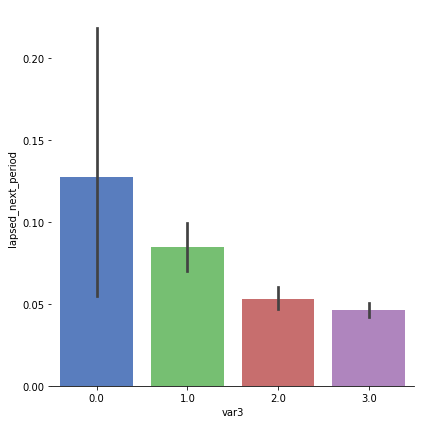

In [35]:
def segment_barplot(var):
    g = sns.factorplot(x=var, y='lapsed_next_period', data=df,
                       kind='bar', size=6, palette='muted')
    g.despine(left=True)

segment_barplot('var3')

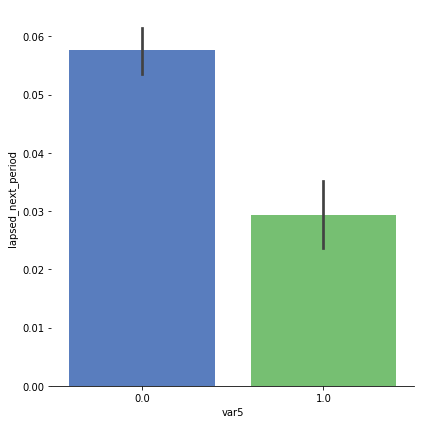

In [37]:
segment_barplot('var5')

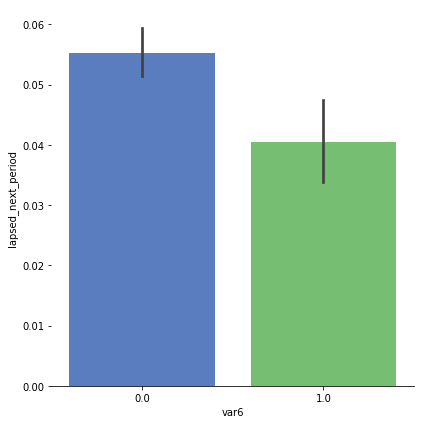

In [38]:
segment_barplot('var6')

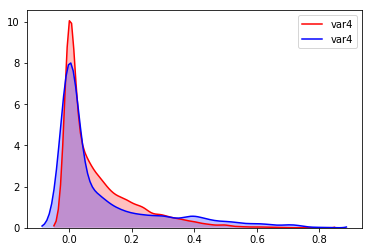

In [42]:
g = sns.kdeplot(df['var4'][df['lapsed_next_period'] == 0], color="Red", shade = True)
g = sns.kdeplot(df['var4'][df['lapsed_next_period'] == 1], ax =g, color="Blue", shade= True)
# g.despine(left=True)